In [93]:
#This notebook is based on Roboflow tutorial on YOLOv8
#https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-track-and-count-vehicles-with-yolov8.ipynb

In [ ]:
!nvidia-smi

Sat Feb 25 08:23:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import cv2

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install pytube

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 KB 1.8 MB/s eta 0:00:00


In [ ]:
from pytube import YouTube
yt = YouTube('https://www.youtube.com/watch?v=6hyLdfYIcxI')
yt.streams.filter().get_by_resolution('720p').download(filename='butterfly.mp4')

'/content/butterfly.mp4'

In [ ]:
!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 25.9/78.2 GB disk)


In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

In [ ]:
#Download custom dataset from roboflow
#https://universe.roboflow.com/henry-ng-lus6a/butterfly-gbuws
!mkdir {HOME}/datasets
%cd {HOME}/datasets

#This link is invalid since it contains the private key
!curl -L "https://app.roboflow.com/ds/AjQJsPRxQq?key=KEY" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content/datasets
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/frame0_jpg.rf.d11387ef0ee6de4f895fa5362b6a7a84.jpg  
 extracting: test/images/frame1000_jpg.rf.7447bf72bd21c2cd21e6397521f35ea5.jpg  
 extracting: test/images/frame1650_jpg.rf.07342b0f17b378f2ca4e64f9c29e9cfa.jpg  
 extracting: test/images/frame650_jpg.rf.c04dd0043f20424124dc68964c21a462.jpg  
   creating: test/labels/
 extracting: test/labels/frame0_jpg.rf.d11387ef0ee6de4f895fa5362b6a7a84.txt  
 extracting: test/labels/frame1000_jpg.rf.7447bf72bd21c2cd21e6397521f35ea5.txt  
 extracting: test/labels/frame1650_jpg.rf.07342b0f17b378f2ca4e64f9c29e9cfa.txt  
 extracting: test/labels/frame650_jpg.rf.c04dd0043f20424124dc68964c21a462.txt  
   creating: train/
   creating: train/images/
 extracting: train/images/frame100_jpg.rf.791072f5cb14ca5ea11865f2cdcc226f.jpg  
 extra

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={HOME}/datasets/data.yaml epochs=25 plots=True

/content
100% 21.5M/21.5M [00:00<00:00, 46.8MB/s]

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/datasets/data.yaml, epochs=25, patience=50, batch=16, imgsz=640, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=

/content


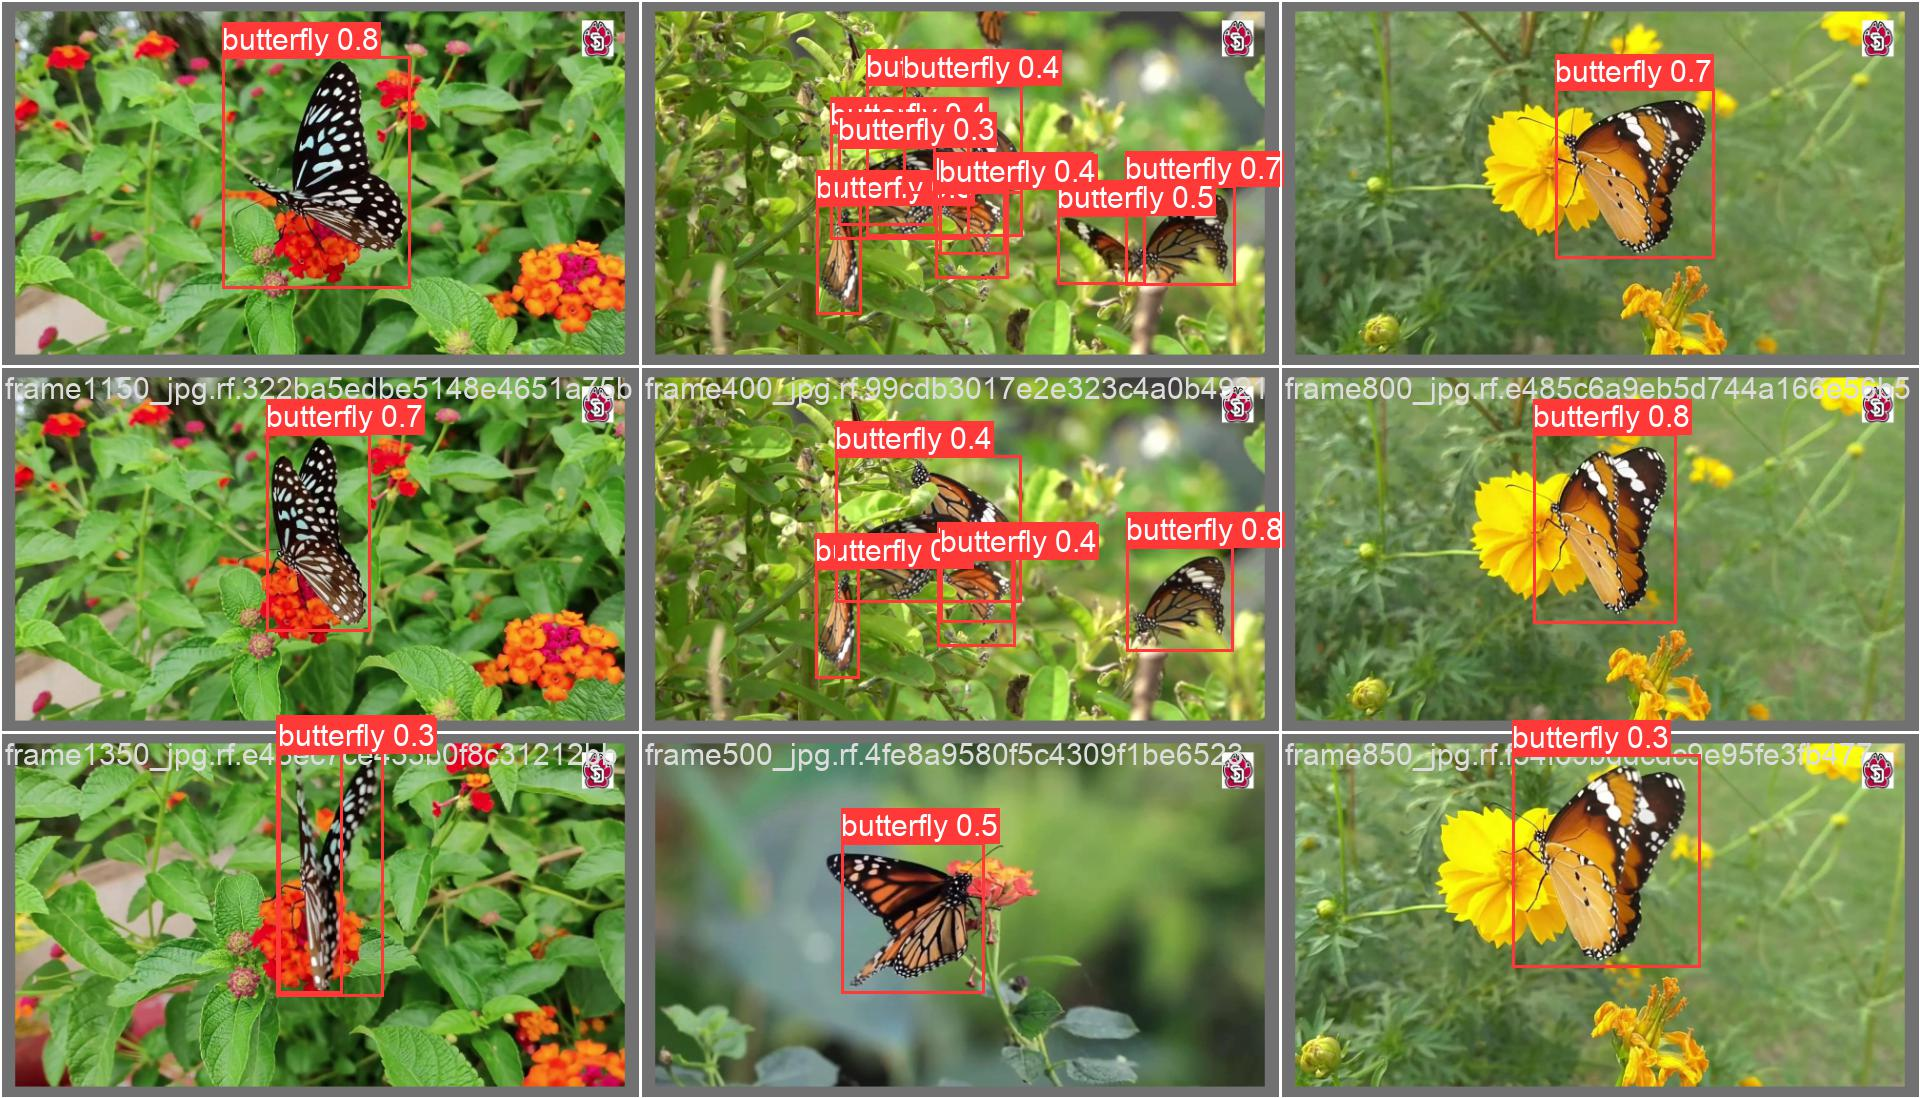

In [ ]:
Image(filename=f'runs/detect/train/val_batch0_pred.jpg', width=600)

In [ ]:
#!zip -r weights.zip runs/detect/train/weights

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
!cd ByteTrack && pip3 install -q -r requirements.txt
!cd ByteTrack && python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections, 
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)
    
    tracker_ids = [None] * len(detections)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [ ]:
from typing import Dict

class Counter:
  def __init__(self, width: int, height: int):
    self.prev_tracked_ids = []
    self.prev_tracked_xy = []
    self.in_count: int = 0
    self.out_count: int = 0
    self.width = width
    self.height = height
  
  def update(self, detections: Detections):
    if not self.prev_tracked_ids:
      for xyxy, _, _, tracker_id in detections:
        if tracker_id is None:
          continue
        self.prev_tracked_xy.append(xyxy)
        self.prev_tracked_ids.append(tracker_id)

    else:
      new_tracked_ids = []
      new_xy = []
      for xyxy, _, _, tracker_id in detections:
        if tracker_id is None:
          continue
        
        new_tracked_ids.append(tracker_id)
        new_xy.append(xyxy)

        # find new entered object
        if tracker_id not in self.prev_tracked_ids:
          x1, y1, x2, y2 = xyxy
          if x1 == 0 or x2 == self.width or y1 == 0 or y2 == self.height:
            self.in_count += 1

      # find exited object
      for i, id in enumerate(self.prev_tracked_ids):
        if id in new_tracked_ids: 
          continue
        x1, y1, x2, y2 = self.prev_tracked_xy[i]
        if x1 == 0 or x2 == self.width or y1 == 0 or y2 == self.height:
          self.out_count += 1

      self.prev_tracked_ids = new_tracked_ids
      self.prev_tracked_xy = new_xy

  def getCount(self) -> set:
    return (self.in_count, self.out_count)

In [ ]:
MODEL = "runs/detect/train/weights/best.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [0]

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/butterfly.mp4"

In [ ]:
counter=Counter(1280,720)

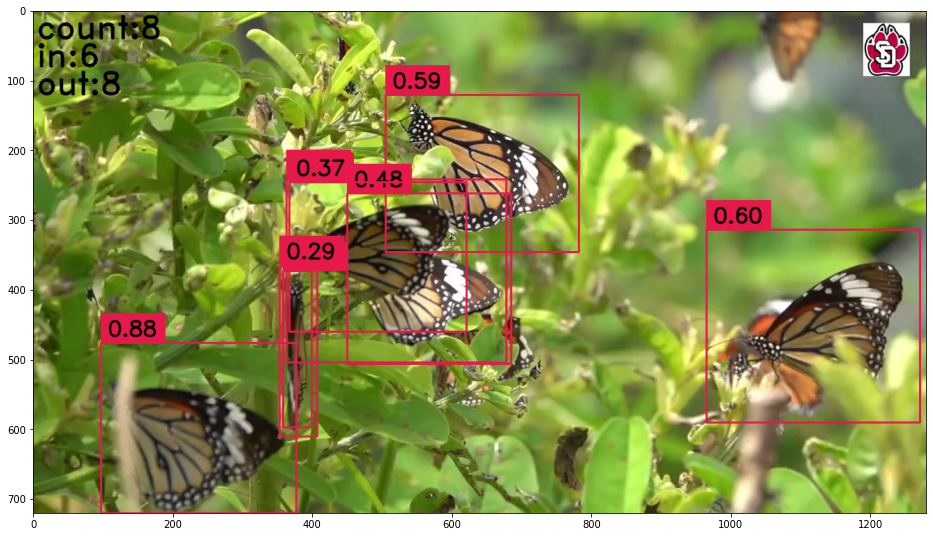

In [ ]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=2, text_scale=1)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
counter.update(detections)
in_count, out_count = counter.getCount()
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections)
cv2.putText(frame, f"count:{len(results[0].boxes)}", (5,40), cv2.FONT_HERSHEY_DUPLEX, 1.5, (0,0,0), 2, cv2.LINE_AA)
cv2.putText(frame, f"in:{in_count}", (5,80), cv2.FONT_HERSHEY_DUPLEX, 1.5, (0,0,0), 2, cv2.LINE_AA)
cv2.putText(frame, f"out:{out_count}", (5,120), cv2.FONT_HERSHEY_DUPLEX, 1.5, (0,0,0), 2, cv2.LINE_AA)
#ImageDraw.Draw(frame).text((15,15), f"{len(results[0].boxes)}", (237, 230, 211))
show_frame_in_notebook(frame, (16, 16))

In [ ]:
TARGET_VIDEO_PATH = f"{HOME}/butterfly-result.mp4"

In [ ]:
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

In [ ]:
video_info

VideoInfo(width=1280, height=720, fps=25, total_frames=2128)

In [ ]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=2, text_scale=1)
counter = Counter(video_info.width, video_info.height)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        counter.update(detections)
        in_count, out_count = counter.getCount()
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections)#, labels=labels)
        cv2.putText(frame, f"count:{len(results[0].boxes)}", (5,40), cv2.FONT_HERSHEY_DUPLEX, 1.5, (0,0,0), 2, cv2.LINE_AA)
        cv2.putText(frame, f"in:{in_count}", (5,80), cv2.FONT_HERSHEY_DUPLEX, 1.5, (0,0,0), 2, cv2.LINE_AA)
        cv2.putText(frame, f"out:{out_count}", (5,120), cv2.FONT_HERSHEY_DUPLEX, 1.5, (0,0,0), 2, cv2.LINE_AA)
        sink.write_frame(frame)

  0%|          | 0/2128 [00:00<?, ?it/s]